Based on: https://towardsdatascience.com/estimating-probabilities-with-bayesian-modeling-in-python-7144be007815

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from scipy.stats import dirichlet
from numpy import ndarray
from numpy.random import RandomState
from dask import compute

sns.set_style("darkgrid")
sns.set_palette("muted")

In [2]:
seed_val = 123
rand = RandomState(seed=seed_val)

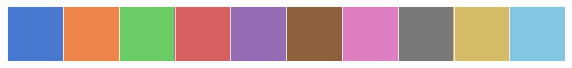

In [3]:
palette = sns.color_palette()
sns.palplot(palette)

# Helpers

In [4]:
def display_probs(labels, probs) -> None:
    for i, lab in enumerate(labels):
        print(f"Label: {lab}\t\tProb: {probs[i]}")

        
def dir_mult_ev(c, alphas) -> float:
    return (c + alphas) / (c.sum() + alphas.sum())


def dir_mult_map(c, alphas) -> float:
    return (alphas + c - 1) / np.sum(alphas + c - 1)


def melt_and_bar_plot(d_frame, ax) -> None:
    melted_df = pd.melt(d_frame, id_vars="alphas", var_name="species", value_name="prevalence")
    sns.barplot(x="alphas", y="prevalence", hue="species", data=melted_df, ax=ax)

    
def color_code_and_legend(ax, n_lines, pal, leg):
    lines = ax.get_lines()[:n_lines]
    for i in range(n_lines):
        lines[i].set_color(pal[i])
    ax.legend(leg, loc=1)

# Define parameters & observations

In [5]:
# Observed data
animals = ["lions", "tigers", "bears"]
c = np.array([3, 2, 1])
n = c.sum()

# Hyperparameters (assume uniform)
alphas = np.array([
    np.array([0.1, 0.1, 0.1]),
    np.array([1, 1, 1]),
    np.array([5, 5, 5]),
    np.array([15, 15, 15])
])

# Expected Value

In [6]:
ev = dir_mult_ev(c, alphas[1])
display_probs(animals, ev)

Label: lions		Prob: 0.4444444444444444
Label: tigers		Prob: 0.3333333333333333
Label: bears		Prob: 0.2222222222222222


In [7]:
evs = compute(np.array([dir_mult_ev(c, a) for a in alphas]))[0]
df = pd.DataFrame(evs, columns=animals)
df["alphas"] = [str(x) for x in alphas]
df

,lions,tigers,bears,alphas
0,0.492063,0.333333,0.174603,[0.1 0.1 0.1]
1,0.444444,0.333333,0.222222,[1. 1. 1.]
2,0.380952,0.333333,0.285714,[5. 5. 5.]
3,0.352941,0.333333,0.313725,[15. 15. 15.]


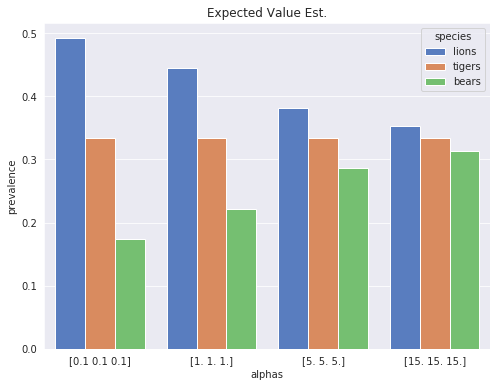

In [8]:
_, ax = plt.subplots(figsize=(8, 6))
melt_and_bar_plot(df, ax)
ax.set_title("Expected Value Est.")
plt.show()

# MAP

In [9]:
map_ests = dir_mult_map(c, alphas[1])
display_probs(animals, map_ests)

Label: lions		Prob: 0.5
Label: tigers		Prob: 0.3333333333333333
Label: bears		Prob: 0.16666666666666666


In [10]:
map_ests = compute(np.array([dir_mult_map(c, a) for a in alphas]))[0]
df = pd.DataFrame(map_ests, columns=animals)
df["alphas"] = [str(x) for x in alphas]
df

,lions,tigers,bears,alphas
0,0.636364,0.333333,0.030303,[0.1 0.1 0.1]
1,0.500000,0.333333,0.166667,[1. 1. 1.]
2,0.388889,0.333333,0.277778,[5. 5. 5.]
3,0.354167,0.333333,0.312500,[15. 15. 15.]


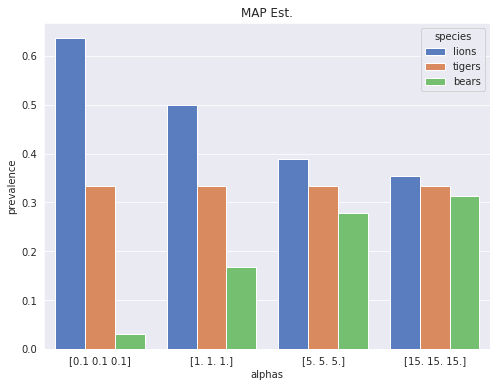

In [11]:
_, ax = plt.subplots(figsize=(8, 6))
melt_and_bar_plot(df, ax)
ax.set_title("MAP Est.")
plt.show()

# Bayesian Modeling
Goal: quantify uncertainty of model

In [12]:
with pm.Model() as model:
    # Parameters of the Multinomial drawn from a Dirichlet
    params = pm.Dirichlet("parameters", a=alphas[1], shape=3)
    # Observations from a Multinomial distribution
    observations = pm.Multinomial("observations", n=6, p=params, shape=3, observed=c)

In [13]:
model

# Sampling from the model

In [14]:
with model:
    # Sample from the posterior
    trace = pm.sample(draws=1000, chains=3, random_seed=seed_val)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [parameters]
Sampling 3 chains, 0 divergences: 100%|██████████| 4500/4500 [00:01<00:00, 4206.89draws/s]


In [15]:
summary = pm.summary(trace, credible_interval=.95)
summary.index = animals
summary

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lions,0.445,0.157,0.152,0.741,0.003,0.002,2447.0,2312.0,2418.0,1558.0,1.0
tigers,0.336,0.152,0.059,0.627,0.003,0.002,2651.0,2350.0,2658.0,1958.0,1.0
bears,0.218,0.132,0.012,0.481,0.003,0.002,2408.0,2085.0,2423.0,1966.0,1.0


In [16]:
trace_df = pd.DataFrame(trace["parameters"], columns=animals)
trace_df.head()

,lions,tigers,bears
0,0.455511,0.333795,0.210693
1,0.333330,0.333653,0.333017
2,0.532198,0.380100,0.087702
3,0.484352,0.398405,0.117243
4,0.511165,0.191978,0.296857


In [17]:
trace_df.shape

(3000, 3)

In [18]:
pvs = trace_df.mean(axis=0)
display_probs(animals, pvs)

Label: lions		Prob: 0.4454167419432058
Label: tigers		Prob: 0.33624757338374833
Label: bears		Prob: 0.21833568467304515


In [19]:
summary[["hpd_2.5%", "hpd_97.5%"]]

,hpd_2.5%,hpd_97.5%
lions,0.152,0.741
tigers,0.059,0.627
bears,0.012,0.481


# Visualizations

## Posterior

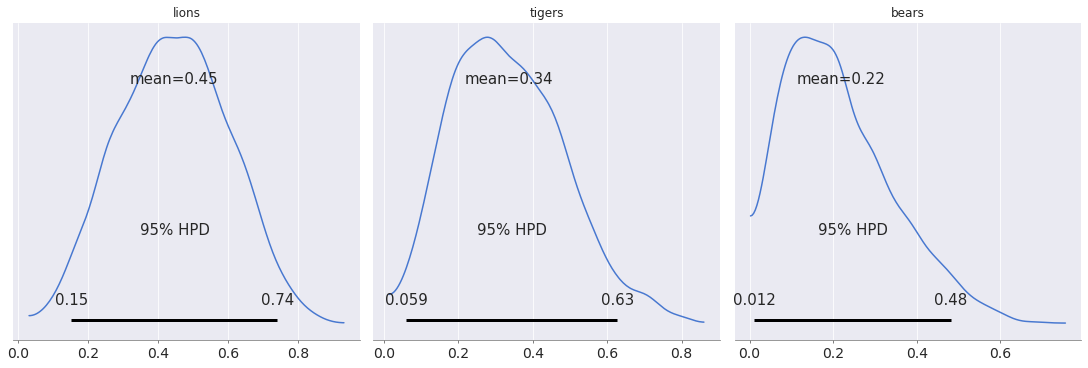

In [20]:
axes = pm.plot_posterior(trace, var_names=["parameters"], figsize=(15, 5), credible_interval=0.95)
for i, a in enumerate(animals):
    axes[i].set_title(a)
plt.show()

## Traceplot

/home/carcook/anaconda3/envs/data-science-env/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/carcook/anaconda3/envs/data-science-env/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/carcook/anaconda3/envs/data-science-env/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


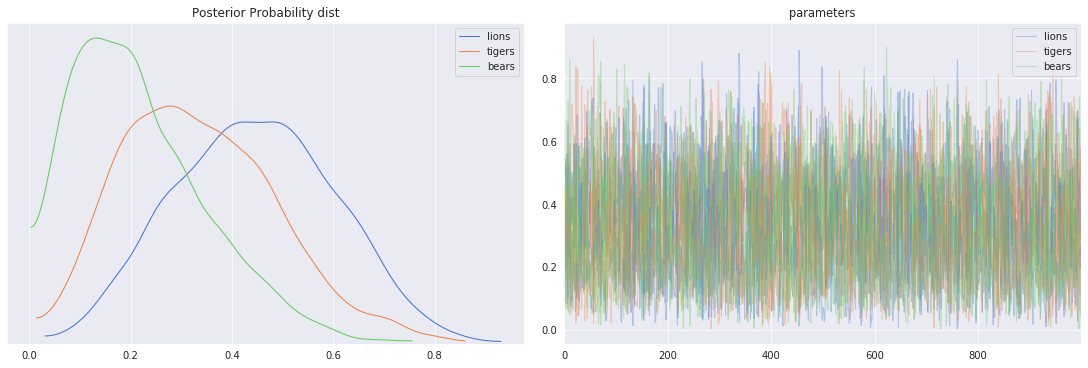

In [21]:
axes = pm.traceplot(trace, var_names=["parameters"], figsize=(15, 5), combined=True)
axes[0][0].set_title("Posterior Probability dist")
color_code_and_legend(axes[0][0], 3, palette, animals)
color_code_and_legend(axes[0][1], 3, palette, animals)
plt.show()

# MAP with PyMC3

In [22]:
with model:
    maxapost = pm.find_MAP()

logp = -1.8042, ||grad|| = 1.118: 100%|██████████| 7/7 [00:00<00:00, 1679.93it/s]


In [23]:
display_probs(animals, maxapost["parameters"])

Label: lions		Prob: 0.4999999599472019
Label: tigers		Prob: 0.33333301020241707
Label: bears		Prob: 0.166667029850381


# Sample from posterior

In [24]:
with model:
    samples = pm.sample_posterior_predictive(trace, samples=1000)

/home/carcook/anaconda3/envs/data-science-env/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:00<00:00, 1053.96it/s]


In [25]:
pd.DataFrame([samples["observations"].mean(axis=0)], columns=animals)

,lions,tigers,bears
0,2.65,2.02,1.33


In [26]:
sample_df = pd.DataFrame(samples["observations"], columns=animals)

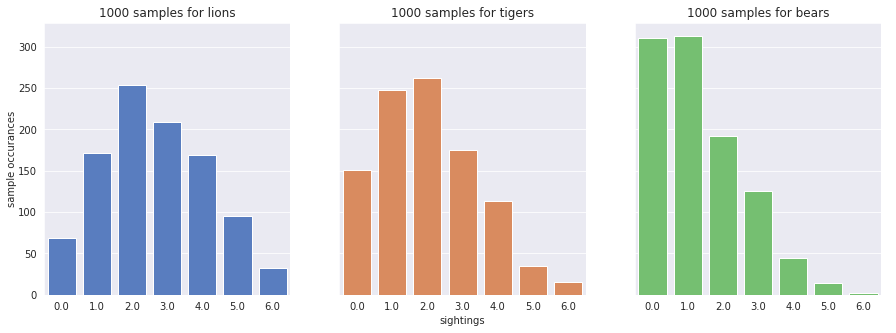

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

for i, animal in enumerate(sample_df.columns):
    counts = sample_df[animal].value_counts()
    sns.barplot(x=counts.index, y=counts.values, color=palette[i], ax=axes[i])
    axes[i].set_title(f"1000 samples for {animal}")
ax = fig.add_subplot(111, frameon=False)
ax.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
ax.grid(False)
ax.set_xlabel("sightings")
ax.set_ylabel("sample occurances")
plt.show()

# Expectations for next observation

In [28]:
next_obs = rand.multinomial(n=1, pvals=pvs.values, size=1000)
next_obs = pd.DataFrame(next_obs, columns=animals).aggregate(np.mean)
next_obs

lions     0.430
tigers    0.338
bears     0.232
dtype: float64

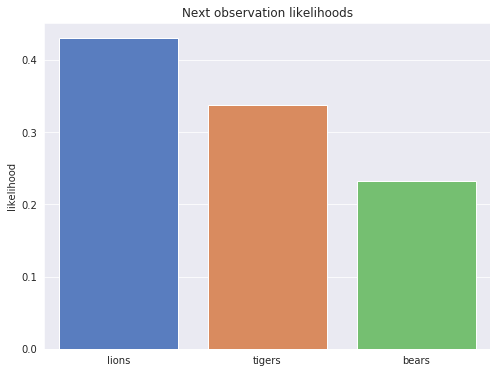

In [29]:
_, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=next_obs.index, y=next_obs.values, palette=palette, ax=ax)
ax.set_ylabel("likelihood")
ax.set_title("Next observation likelihoods")
plt.show()

# More observations

In [30]:
cs = np.array([
    [3, 2, 1],
    [2, 3, 1],
    [3, 2, 1],
    [2, 3, 1]
])

with pm.Model() as model:
    params = pm.Dirichlet("parameters", a=alphas[1], shape=3)
    observations = pm.Multinomial("observations", n=6, p=params, shape=3, observed=cs)
    trace = pm.sample(draws=1000, chains=3, random_seed=seed_val)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [parameters]
Sampling 3 chains, 0 divergences: 100%|██████████| 4500/4500 [00:01<00:00, 3592.08draws/s]


In [31]:
summary = pm.summary(trace, credible_interval=.95)
summary.index = animals
summary

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lions,0.406,0.095,0.224,0.586,0.002,0.001,2855.0,2808.0,2853.0,2134.0,1.0
tigers,0.409,0.093,0.243,0.595,0.002,0.001,2653.0,2608.0,2650.0,2082.0,1.0
bears,0.186,0.075,0.054,0.332,0.002,0.001,2428.0,2185.0,2508.0,2225.0,1.0


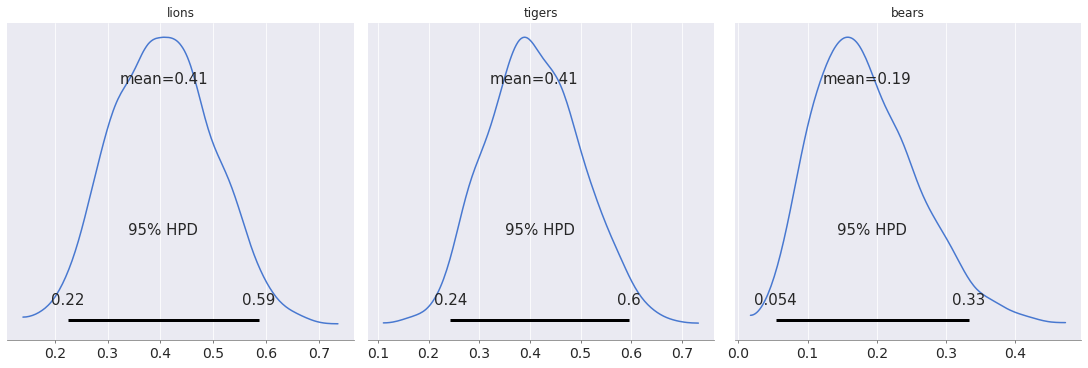

In [32]:
axes = pm.plot_posterior(trace, var_names=["parameters"], figsize=(15, 5), credible_interval=0.95)
for i, a in enumerate(animals):
    axes[i].set_title(a)
plt.show()